# Linear Models

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Labels

In [2]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
ids_with_labels = wisc_labels.index
# display(wisc_labels)

## Get Data

In [3]:
def get_id_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

def has_label(subject_id):
    return True if subject_id in ids_with_labels else False

In [44]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_yeo_fc'
fc_paths = glob.glob(fc_path + '/**/yeo_fc.npy', recursive=True)

measure_text = "WISC_FSIQ"
measure_col = f'assessment WISC,{measure_text}'
age_col = 'assessment Basic_Demos,Age'

fpn_indices = np.triu_indices(11, k=1)
dmn_indices = (np.triu_indices(8, k=1)[0] + 11, np.triu_indices(8, k=1)[1] + 11)

within_fpn = []
within_dmn = []
between_fpn_dmn = []
measures = []
ages = []

for path in fc_paths:
    subject_id = get_id_from_path(path)
    
    if not has_label(subject_id):
        continue
    
    subject_fc = np.load(path)
    within_fpn.append(subject_fc[fpn_indices])
    within_dmn.append(subject_fc[dmn_indices])
    between_fpn_dmn.append(subject_fc[:11, 11:].flatten('C'))
    
    measures.append(wisc_labels.at[subject_id, measure_col])
    ages.append(wisc_labels.at[subject_id, age_col])
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(subject_fc)
#     a = np.zeros((11, 11))
#     a[fpn_indices] = subject_fc[fpn_indices]
#     plt.imshow(a)
#     b = np.zeros((8, 8))
#     b[np.triu_indices(8, k=1)] = subject_fc[dmn_indices]
#     plt.imshow(b)
#     plt.imshow(subject_fc[:11, 11:])

print("Number of functional connectivities:", len(within_fpn))
print("Number of within-FPN connections:", within_fpn[0].shape)
print("Number of within-DMN connections:", within_dmn[0].shape)
print("Number of between-FPN-DMN connections:", between_fpn_dmn[0].shape)

Number of functional connectivities: 577
Number of within-FPN connections: (55,)
Number of within-DMN connections: (28,)
Number of between-FPN-DMN connections: (88,)


In [22]:
# Preprocess the connections by reducing them to the mean
def mean_connections(connections):
    means = [np.mean(sub) for sub in connections]
    return np.array(means)

In [45]:
X_fpn = mean_connections(within_fpn)
X_dmn = mean_connections(within_dmn)
X_fpn_dmn = mean_connections(between_fpn_dmn)
X = np.array([X_fpn, X_dmn, X_fpn_dmn])
X_names = ["FPN", "DMN", "FPN+DMN"]
y = np.array(measures)

print("X_fpn:", X_fpn.shape, "X_dmn:", X_dmn.shape,
      "X_fpn_dmn:", X_fpn_dmn.shape, "X:", X.shape, 
      "y shape:", y.shape)

X_fpn: (577,) X_dmn: (577,) X_fpn_dmn: (577,) X: (3, 577) y shape: (577,)


## Linear Regression

In [27]:
from scipy import stats

In [46]:
y_preds = []
for network, name in zip(X, X_names):
    m, b, r, p, std_err = stats.linregress(network, y)
    print(f"{name}: y = {m:.2f}x + {b:.2f}, r = {r:.2f}, p = {p:.2f}")
    
    y_pred = m * network + b
    y_preds.append(y_pred)

FPN: y = -5.46x + 102.78, r = -0.04, p = 0.40
DMN: y = -15.09x + 104.13, r = -0.09, p = 0.02
FPN+DMN: y = -13.05x + 102.95, r = -0.08, p = 0.04


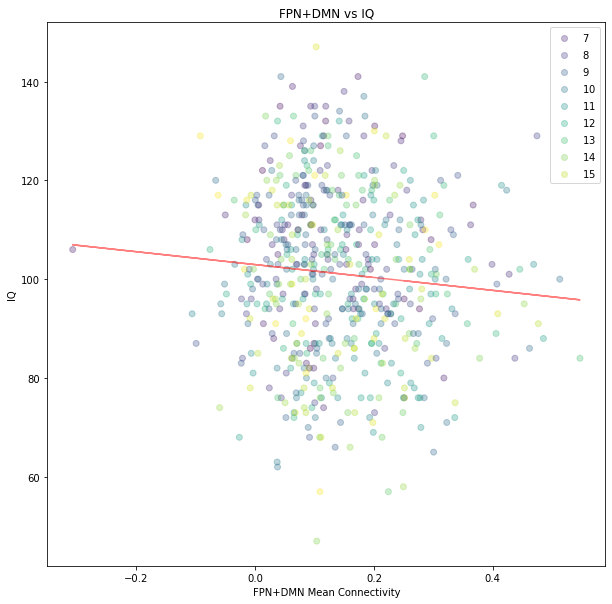

In [50]:
network = 2  # FPN = 0, DMN = 1, FPN_DMN = 2
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X[network], y, c=ages, alpha=0.3, label='Ground Truth')
plt.plot(X[network], y_preds[network], alpha=0.5, color='red', label="Predictions")
plt.title(f"{X_names[network]} vs IQ")
plt.xlabel(f'{X_names[network]} Mean Connectivity')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()